In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kaggle
import re
from fancyimpute import KNN
from sklearn.neighbors import LocalOutlierFactor
from scipy import stats
import seaborn as sns


# 1. COLETA

### Web Scraping 

```$ python3 extracting_tvshows_status.py```

In [2]:

df_metacritic = pd.read_csv('status/metacritic.csv')
# Dados extradios do site Metacritic

### Kaggle Datasets

In [3]:
kaggle.api.authenticate()

# https://www.kaggle.com/oscarfry/tvtime-shows?select=tvtimeshows.csv
kaggle.api.dataset_download_files('oscarfry/tvtime-shows', path='./data/tvtimeshows', unzip = True)

# https://www.kaggle.com/ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney 
kaggle.api.dataset_download_files('ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney', path='./data/streamings', unzip = True)

# https://www.kaggle.com/unanimad/emmy-awards
kaggle.api.dataset_download_files('unanimad/emmy-awards', path='./data/awards', unzip = True)

# https://www.kaggle.com/unanimad/golden-globe-awards
kaggle.api.dataset_download_files('unanimad/golden-globe-awards', path='./data/awards' , unzip = True)

In [4]:
df_tvtime = pd.read_csv('data/tvtimeshows/tvtimeshows.csv')
# df_tvtime.head()

df_streamings = pd.read_csv('data/streamings/tv_shows.csv')
# df_streamings.head()

df_award_emmy = pd.read_csv('data/awards/the_emmy_awards.csv')
# df_award_emmy.head()

df_award_goldenglobe = pd.read_csv('data/awards/golden_globe_awards.csv')
# df_award_goldenglobe.head()

# PRÉ-PROCESSAMENTO

## Processando os dados do metacritcs

O DataFrame `df_metacritcs` é fruto da extração de dados de um site que mostra qual o status das séries em cada ano, entre 2013 e 2020

O código a seguir processa esses dados filtrando as redes mais populares, inferindo o status a partir do texto encontrado no site e juntando os dados capturados em cada ano em uma informação única para cada série

Estas operações resultam no DataFrame `df_metacritic_aggregated`

In [5]:
def filter_networks(df_tt, networks): 
    column_names = list(df_tt.columns)
    df_most_popular = pd.DataFrame(columns = column_names)
    for i in networks:
        df = df_tt[df_tt['tv_network'].str.contains(i, flags=re.IGNORECASE, regex=True, na=False)]
        df['tv_network'] = i
        df_most_popular = df_most_popular.append(df,ignore_index=True)
    return df_most_popular

In [6]:
# filtrar dados somente de redes de TV populares

popular_networks = [ "ABC", "CBS", "NBC", "NETFLIX", "AMAZON", "DISNEY", "HULU", "HBO", "APPLE", "FOX", "MTV",'FX','SYFY','THE CW','FREEF','TNT','IFC','STRZ','TVL','SHOWTIME','AMC','USA', "TBS", "YHOO", "YT"]

df_metacritic_popular_networks = filter_networks(df_metacritic, popular_networks)

In [7]:
# infere a 'categoria' do status a partir do texto encontrado no site
def standardize_status(df): 
    column_names = list(df.columns)
    column_names.append('changed_network')
    df_clean = pd.DataFrame(columns = column_names)
    df_clean = df.copy()
    df_clean['changed_network'] = False

    dict_status = {
       'canceled' : ['CANCELED','order rescinded','Likely to end','won\'t air','Pulled from schedule','Cancellation','not return','not be moving forward', 'won\'t be back', 'No plans', 'not progressing', 'killed', 'not on schedule', 'season unlikely', 'Postponed indefinitely', 'Production halted', r'not included in .* plans', 'pulled from  schedule', 'pulled out'],
       'renewed' : ['Renew','order',r'S(\d+) confirmed','return on', 'returns on','Renwed', 'in production', 'in development', 'will air', r'S(\d+) announced', 'revival', 'returns later', 'will likely return', 'season in', 'to air', 'season announced'],
       'renewed_but' : ['Moved to', 'Moving from', "Moving to", 'Moves to', 'moved from','Moved from', 'will move to', 'Moving back to', 'picked up'],
       'delayed' : ['delayed', 'delay'],
       'end' : ['Ending','ended', 'Final season','miniseries', 'concluding with', 'will end with', '1-season show', 'last aired', 'miniseres'],
       'animated' : ['animated','anime'],
       'nacionality':  ['Brazilian' , 'Spanish', 'German', 'Korean', 'Japanese', 'Swedish', 'French', 'Argentinian', 'Austalian', 'British', 'Belgian', 'Polish', 'Chinese', 'Italian', 'Mexican', 'Indian', 'Colombian', 'Thai', 'Taiwanese', 'Turkish', 'Norwegian', 'Lebanese', 'Israeli', 'Arabic', 'Dutch', 'Argentine','UK','Irish','USA', 'Australian', 'Philippine', 'Canadian', 'Russian', 'South African', 'Danish','Finnish']
    }

    for key in dict_status:
       for value in dict_status[key]:
          new_value = key
          if key in ['animated', 'nacionality']:
             new_value = np.nan
          condition = df_clean['status'].str.contains(value, flags=re.IGNORECASE, regex=True, na=False)
          df_clean['status'] =  np.where(condition, new_value, df_clean['status'])
    df_clean['changed_network'] = np.where(df_clean['status'] == 'renewed_but', True, False)
   #  print(df_clean['status'].unique())
    df_clean['status'] = np.where(df_clean['status'].isin(dict_status.keys()), df_clean['status'], np.nan)
    return df_clean

In [8]:
df_metacritic_infered_status = standardize_status(df_metacritic_popular_networks)
df_metacritic_infered_status.status.unique()

array(['renewed', 'canceled', 'delayed', nan, 'end', 'renewed_but'],
      dtype=object)

Text(0.5, 0, 'Frequency')

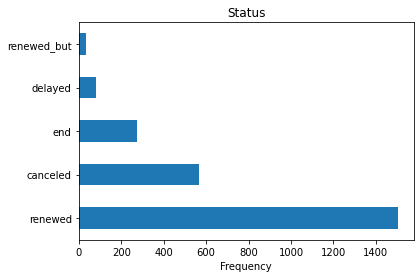

In [9]:
df_metacritic_infered_status.status.value_counts().plot(kind='barh')
plt.title('Status')
plt.xlabel('Frequency')

In [10]:
def clean_season_name(df):
    df_clean = df.copy()
    df_clean['season'].replace({
        r".*SEASON\s*(\d+).*": r"\1",
        r".*SEASONS\s*\d+\s*/\s*(\d+).*": r"\1",
        r".*S\s*(\d+).*": r"\1",
        r".*SEA[.]\s*(\d+).*": r"\1",
        r".*SN[.]\s*(\d+).*": r"\1"
    }, regex=True, inplace=True)
    # deletar valores que nao sao um numero
    df_clean['season'] = np.where(df_clean['season'].str.match(r"\d+", na=False), df_clean.season, np.nan)
    df_clean['season'] = df_clean['season'].astype('float')
    return df_clean

Text(0.5, 0, 'Frequencia')

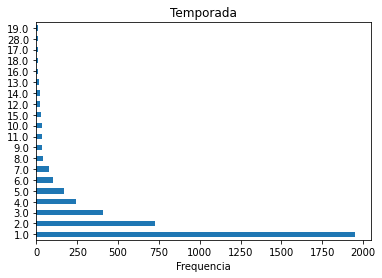

In [11]:
df_metacritic_clean_season_name = clean_season_name(df_metacritic_infered_status)

df_metacritic_clean_season_name.season.unique()

df_metacritic_clean_season_name.season.value_counts().head(20).plot(kind='barh')
plt.title('Temporada')
plt.xlabel('Frequencia')


In [12]:
# Esta funcao retorna um novo DataFrame com uma nova coluna 'lower_name', que consiste dos valores da coluna @col_name ignorando todos os caracteres que nao sao letras e numeros, e transformando o restante em lower case 
def add_lower_col(df, col_name):
    df_new = df.copy()
    df_new['lower_name'] = df_new[col_name].str.replace('[^a-zA-Z0-9]', '')
    df_new['lower_name'] = df_new['lower_name'].str.lower()
    return df_new

In [13]:
df_metacritic_clean_season_name = add_lower_col(df_metacritic_clean_season_name, 'name')

df_metacritic_aggregated = df_metacritic_clean_season_name[['lower_name', 'name', 'status', 'tv_network', 'changed_network', 'ano', 'season']].groupby(['lower_name'], as_index=False).agg({
    'name': 'last',
    'changed_network': 'any',
    'status': 'last',
    'ano': 'last',
    'tv_network': 'last',
    'season': 'last',
})


df_metacritic_aggregated.rename(
    inplace=True,
    columns={'season': 'last_info_season', 'ano': 'last_info_year'})

df_metacritic_aggregated.head()

,lower_name,name,changed_network,status,last_info_year,tv_network,last_info_season
0,100000pyramid,"$100,000 Pyramid",False,renewed,2020,ABC,5.0
1,10yearoldtom,10-Year-Old Tom,False,NaN,2020,HBO,1.0
2,112263,11/22/63,False,NaN,2015,HULU,1.0
3,12monkeys,12 Monkeys,False,end,2018,SYFY,4.0
4,13reasonswhy,13 Reasons Why,False,end,2020,NETFLIX,4.0


Text(0.5, 0, 'Frequencia')

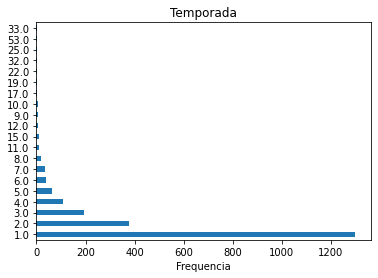

In [14]:
df_metacritic_aggregated.last_info_season.value_counts().head(20).plot(kind='barh')
plt.title('Temporada')
plt.xlabel('Frequencia')

In [15]:
df_metacritic_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 0 to 2205
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lower_name        2206 non-null   object 
 1   name              2206 non-null   object 
 2   changed_network   2206 non-null   bool   
 3   status            1245 non-null   object 
 4   last_info_year    2206 non-null   int64  
 5   tv_network        2206 non-null   object 
 6   last_info_season  2201 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 122.8+ KB


## Juntando dados de outros datasets

`df_tvtime` contém os dados do dataset do app tvtime extraído do kaggle. Colunas importantes: `followers`, `mean_rate`, `number_of_seasons`, `runtime`

`df_streamings` contém os dados sobre series incluindo notas do "Rotten Tomatoes" e "IMDb", este também foi extraído do kaggle. Colunas importantes: `Year`, `Age`, `Rotten Tomatoes`, `IMDb`.

O código abaixo remove séries duplicadas do conjunto e agrega estes dados aos dados obtidos do metacritic, resultando no DataFrame `df_joined_datasets`.

In [16]:
#tvtime possui filmes e series, removendo linhas que a duracao do producao seja > 90
df_tvtime_rmv_movies = df_tvtime[df_tvtime['runtime'] <= 90]
#algumas series tem o formato do nome: taken (2017), removendo o ano do nome
df_tvtime_rmv_movies['name'] = df_tvtime_rmv_movies['name'].str.replace(r'[(]\d{4}[)]', '', regex=True)
#Muitas vezes quando o dado nao existe, o dataset possui 0 no campo
df_tvtime_rmv_movies['runtime'] = np.where(df_tvtime_rmv_movies['runtime'] == 0, np.nan, df_tvtime_rmv_movies['runtime'])
df_tvtime_rmv_movies['mean_rate'] = np.where(df_tvtime_rmv_movies['mean_rate'] == 0, np.nan, df_tvtime_rmv_movies['mean_rate'])

df_tvtime_rmv_movies = add_lower_col(df_tvtime_rmv_movies, 'name')
df_tvtime_nodup = df_tvtime_rmv_movies[['lower_name', 'name', 'network', 'followers', 'mean_rate', 'number_of_seasons', 'runtime']].groupby(['lower_name'], as_index=False).apply(lambda x: x.loc[x.followers.idxmax()])

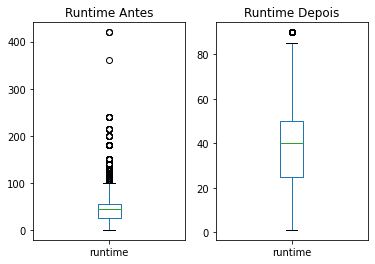

In [17]:
figure, axes = plt.subplots(1, 2)
df_tvtime.runtime.plot.box(ax=axes[0])
df_tvtime_rmv_movies.runtime.plot.box(ax=axes[1])
axes[0].title.set_text('Runtime Antes')
axes[1].title.set_text('Runtime Depois')

In [18]:
df_streamings = add_lower_col(df_streamings, 'Title')
df_streaming_nodup = df_streamings[['Title', 'Year', 'Age', 'Rotten Tomatoes', 'IMDb', 'lower_name']].groupby(['lower_name'], as_index=False).apply(lambda x: x.loc[x.IMDb.fillna(0).idxmax()])

## Juntando os Datasets

In [19]:
df_metacritic_aggregated = add_lower_col(df_metacritic_aggregated, 'name')

df_metacritic_tvtime = pd.merge(df_metacritic_aggregated, df_tvtime_nodup, on="lower_name", how="left")
df_joined_datasets = pd.merge(df_metacritic_tvtime, df_streaming_nodup, on="lower_name", how="left")

df_joined_datasets = df_joined_datasets[['name_x', 'changed_network', 'status', 'tv_network', 'last_info_year', 'followers', 'mean_rate', 'number_of_seasons', 'runtime', 'Age', 'IMDb', 'Rotten Tomatoes', 'Year']]

#  Renomeando algumas colunas
df_joined_datasets.rename(
    inplace=True,
    columns={
        'followers': 'tvtime_followers',
        'mean_rate': 'tvtime_rate',
        'number_of_seasons': 'no_seasons',
        'IMDb': "imdb_rate",
        "Rotten Tomatoes": "rotten_tomatoes_rate",
        "name_x": "name",
        "runtime": "eps_duration",
        "last_info_year": "metacritc_last_info_year",
        "Year": "released_year",
        "Age": "age_rating"})

# Removendo '%' da nota do Rotten Tomatoes
df_joined_datasets['rotten_tomatoes_rate'].replace({
    r"(\d+)\%": r"\1"
}, regex=True, inplace=True)
# Transformando a nota do Rotten Tomatoes em um float
df_joined_datasets['rotten_tomatoes_rate'] = df_joined_datasets['rotten_tomatoes_rate'].astype('float')
df_joined_datasets.head()

,name,changed_network,status,tv_network,metacritc_last_info_year,tvtime_followers,tvtime_rate,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year
0,"$100,000 Pyramid",False,renewed,ABC,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10-Year-Old Tom,False,NaN,HBO,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11/22/63,False,NaN,HULU,2015,NaN,NaN,NaN,NaN,18+,8.2,80.0,2016.0
3,12 Monkeys,False,end,SYFY,2018,242876.0,4.73,4.0,45.0,16+,7.7,88.0,2015.0
4,13 Reasons Why,False,end,NETFLIX,2020,3631287.0,4.64,3.0,60.0,18+,7.8,39.0,2017.0


## Juntando informações sobre premiações

Os datasets `df_award_emmy` e `df_award_goldenglobe` contêm dados sobre premiações de filmes e séries. Ambos contam com a colunas: `nominee`, que possui o nome da produção; `win`, que é `True` se a produção ganhou o prêmio.

O código abaixo calcula quantas premiações as produções foram nomeadas e quantas destas foram conquistas, em seguida este dados são integrados ao DataFrame com os dados sobre as séries (`df_joined_datasets`) em um DataFrame final com todos os dados (`df_tv_shows`).

In [20]:
df_award_emmy = add_lower_col(df_award_emmy, 'nominee')
df_award_goldenglobe = add_lower_col(df_award_goldenglobe, 'nominee')
df_emmy_agg = df_award_emmy.groupby(['lower_name'], as_index=False).agg({
    'win': ['count', 'sum'],
    'nominee': 'last'
})
df_goldenglobe_agg = df_award_goldenglobe.groupby(['lower_name'],as_index=False).agg({
    'win': ['count', 'sum'],
    'nominee': 'last'
})

df_awards_joined = pd.merge(df_emmy_agg, df_goldenglobe_agg, on='lower_name', how='outer')
df_awards_joined.head()


lower_name win_x       \
                                        count  sum   
0                       100centrestreet   1.0  0.0   
1                100yearsofhopeandhumor   1.0  0.0   
2          102minutesthatchangedamerica   4.0  3.0   
3                                   105   1.0  0.0   
4  10daysthatunexpectedlychangedamerica   1.0  1.0   

                                   nominee_x win_y     nominee_y  
                                        last count sum      last  
0                          100 Centre Street   NaN NaN       NaN  
1                100 Years Of Hope And Humor   NaN NaN       NaN  
2           102 Minutes That Changed America   NaN NaN       NaN  
3                                       10.5   NaN NaN       NaN  
4  10 Days That Unexpectedly Changed America   NaN NaN       NaN

In [21]:
df_awards_count = pd.DataFrame(columns=['nominee', 'awards_won', 'awards_nominated'])
df_awards_count['nominee'] = np.where(df_awards_joined['nominee_y']['last'].isnull(), df_awards_joined['nominee_x']['last'], df_awards_joined['nominee_y']['last'])
df_awards_count['awards_nominated'] = df_awards_joined['win_x']['count'].fillna(0) + df_awards_joined['win_y']['count'].fillna(0)
df_awards_count['awards_won'] = df_awards_joined['win_x']['sum'].fillna(0) + df_awards_joined['win_y']['sum'].fillna(0)

df_awards_count.head()

,nominee,awards_won,awards_nominated
0,100 Centre Street,0.0,1.0
1,100 Years Of Hope And Humor,0.0,1.0
2,102 Minutes That Changed America,3.0,4.0
3,10.5,0.0,1.0
4,10 Days That Unexpectedly Changed America,1.0,1.0


In [22]:
df_tv_shows = pd.merge(add_lower_col(df_joined_datasets, 'name'), add_lower_col(df_awards_count, 'nominee'), on="lower_name", how="left")
df_tv_shows.drop(columns=["nominee", "lower_name"], inplace=True)

df_tv_shows.head()

,name,changed_network,status,tv_network,metacritc_last_info_year,tvtime_followers,tvtime_rate,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year,awards_won,awards_nominated
0,"$100,000 Pyramid",False,renewed,ABC,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10-Year-Old Tom,False,NaN,HBO,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11/22/63,False,NaN,HULU,2015,NaN,NaN,NaN,NaN,18+,8.2,80.0,2016.0,0.0,1.0
3,12 Monkeys,False,end,SYFY,2018,242876.0,4.73,4.0,45.0,16+,7.7,88.0,2015.0,NaN,NaN
4,13 Reasons Why,False,end,NETFLIX,2020,3631287.0,4.64,3.0,60.0,18+,7.8,39.0,2017.0,0.0,1.0


In [23]:
df_tv_shows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 0 to 2205
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      2206 non-null   object 
 1   changed_network           2206 non-null   bool   
 2   status                    1245 non-null   object 
 3   tv_network                2206 non-null   object 
 4   metacritc_last_info_year  2206 non-null   int64  
 5   tvtime_followers          1469 non-null   float64
 6   tvtime_rate               1335 non-null   float64
 7   no_seasons                1469 non-null   float64
 8   eps_duration              1399 non-null   float64
 9   age_rating                902 non-null    object 
 10  imdb_rate                 1031 non-null   float64
 11  rotten_tomatoes_rate      607 non-null    float64
 12  released_year             1036 non-null   float64
 13  awards_won                362 non-null    float64
 14  awards_n

# PRE PROCESSAMENTO 1


## Fazendo imputação básica através do conhecimento prévio do dataset

1. Quando não existe informações sobre premiações quer dizer que as séries não foram nomeadas.
2. Series que passaram muito tempo sem receber atualiação de status no metacritic são consideradas canceladas, consideramos 3-4 anos como o tempo máximo que uma temporada fica em produção

In [24]:
df_tv_shows_first_impute = df_tv_shows.copy()
df_tv_shows_first_impute['awards_won'].fillna(0, inplace=True)
df_tv_shows_first_impute['awards_nominated'].fillna(0, inplace=True)

# imputar 'canceled' no status de séries que não foram atualizadas nos últimos 3 anos
too_old_condition = df_tv_shows_first_impute['metacritc_last_info_year'] < 2018
df_tv_shows_first_impute['status'] = np.where(too_old_condition, df_tv_shows_first_impute['status'].fillna('canceled'), df_tv_shows_first_impute['status'])
df_tv_shows_first_impute['status'] = np.where(too_old_condition & (df_tv_shows_first_impute['status'] == 'renewed'), 'canceled', df_tv_shows_first_impute['status'])


## Descrevendo que dados são categóricos

In [25]:
df_tv_shows_categorical = df_tv_shows_first_impute.copy()

df_tv_shows_categorical.status = df_tv_shows_categorical.status.astype('category')
df_tv_shows_categorical.age_rating = df_tv_shows_categorical.age_rating.astype('category')

df_tv_shows_categorical.metacritc_last_info_year =  df_tv_shows_categorical.metacritc_last_info_year.astype('category')

df_tv_shows_categorical.awards_nominated =  df_tv_shows_categorical.awards_nominated.astype('category')
df_tv_shows_categorical.awards_won =  df_tv_shows_categorical.awards_won.astype('category')

df_tv_shows_categorical.no_seasons =  df_tv_shows_categorical.no_seasons.astype('category')

#epi de 20 min geralmente comedia, 45/60 drama 
# df_tv_shows_categorical.eps_duration =  df_tv_shows_categorical.eps_duration.astype('category')
df_tv_shows_categorical.tv_network = df_tv_shows_categorical.tv_network.astype('category')

df_tv_shows_categorical.released_year = df_tv_shows_categorical.released_year.astype('category')


In [26]:
df_tv_shows_categorical.tv_network.cat.categories

Index(['ABC', 'AMAZON', 'AMC', 'APPLE', 'CBS', 'DISNEY', 'FOX', 'FREEF', 'FX',
       'HBO', 'HULU', 'IFC', 'MTV', 'NBC', 'NETFLIX', 'SHOWTIME', 'STRZ',
       'SYFY', 'TBS', 'THE CW', 'TNT', 'TVL', 'USA', 'YHOO', 'YT'],
      dtype='object')

In [27]:
# usando info pra mostrar o memory usage diminuindo

print(df_tv_shows.info(),'\n')
print(df_tv_shows_categorical.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2206 entries, 0 to 2205
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      2206 non-null   object 
 1   changed_network           2206 non-null   bool   
 2   status                    1245 non-null   object 
 3   tv_network                2206 non-null   object 
 4   metacritc_last_info_year  2206 non-null   int64  
 5   tvtime_followers          1469 non-null   float64
 6   tvtime_rate               1335 non-null   float64
 7   no_seasons                1469 non-null   float64
 8   eps_duration              1399 non-null   float64
 9   age_rating                902 non-null    object 
 10  imdb_rate                 1031 non-null   float64
 11  rotten_tomatoes_rate      607 non-null    float64
 12  released_year             1036 non-null   float64
 13  awards_won                362 non-null    float64
 14  awards_n

## Valores Ausentes

### Usaremos o KNN do fancyimpute 
[Github](https://github.com/iskandr/fancyimpute) 

A variety of matrix completion and imputation algorithms implemented in Python 3.6.

```pip3 install fancyimpute```

In [28]:
# Ajeitando o dataframe para poder usar como input no KNN
df_knn_input = df_tv_shows_categorical.drop(columns=['name'])

df_knn_input.status = df_knn_input.status.cat.codes
df_knn_input.age_rating = df_knn_input.age_rating.cat.codes
df_knn_input.metacritc_last_info_year =  df_knn_input.metacritc_last_info_year.cat.codes
df_knn_input.awards_nominated =  df_knn_input.awards_nominated.cat.codes
df_knn_input.awards_won =  df_knn_input.awards_won.cat.codes
df_knn_input.no_seasons =  df_knn_input.no_seasons.cat.codes
# df_knn_input.eps_duration =  df_knn_input.eps_duration.cat.codes
df_knn_input.tv_network =  df_knn_input.tv_network.cat.codes
df_knn_input.released_year = df_knn_input.released_year.cat.codes

In [29]:
df_knn = KNN(k=3).fit_transform(df_knn_input)

Imputing row 1/2206 with 5 missing, elapsed time: 1.153
Imputing row 101/2206 with 2 missing, elapsed time: 1.162
Imputing row 201/2206 with 5 missing, elapsed time: 1.169
Imputing row 301/2206 with 5 missing, elapsed time: 1.175
Imputing row 401/2206 with 1 missing, elapsed time: 1.181
Imputing row 501/2206 with 2 missing, elapsed time: 1.187
Imputing row 601/2206 with 0 missing, elapsed time: 1.196
Imputing row 701/2206 with 0 missing, elapsed time: 1.202
Imputing row 801/2206 with 0 missing, elapsed time: 1.207
Imputing row 901/2206 with 0 missing, elapsed time: 1.215
Imputing row 1001/2206 with 4 missing, elapsed time: 1.221
Imputing row 1101/2206 with 1 missing, elapsed time: 1.228
Imputing row 1201/2206 with 1 missing, elapsed time: 1.235
Imputing row 1301/2206 with 2 missing, elapsed time: 1.241
Imputing row 1401/2206 with 5 missing, elapsed time: 1.246
Imputing row 1501/2206 with 2 missing, elapsed time: 1.251
Imputing row 1601/2206 with 1 missing, elapsed time: 1.258
Imputing 

In [30]:
df_knn_result = pd.DataFrame(data=df_knn[0:,0:],columns=['changed_network', 'status', 'tv_network', 'metacritc_last_info_year', 'tvtime_followers', 'tvtime_rate', 'no_seasons', 'eps_duration', 'age_rating', 'imdb_rate', 'rotten_tomatoes_rate', 'released_year', 'awards_won', 'awards_nominated'])

df_knn_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2206 entries, 0 to 2205
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   changed_network           2206 non-null   float64
 1   status                    2206 non-null   float64
 2   tv_network                2206 non-null   float64
 3   metacritc_last_info_year  2206 non-null   float64
 4   tvtime_followers          2206 non-null   float64
 5   tvtime_rate               2206 non-null   float64
 6   no_seasons                2206 non-null   float64
 7   eps_duration              2206 non-null   float64
 8   age_rating                2206 non-null   float64
 9   imdb_rate                 2206 non-null   float64
 10  rotten_tomatoes_rate      2206 non-null   float64
 11  released_year             2206 non-null   float64
 12  awards_won                2206 non-null   float64
 13  awards_nominated          2206 non-null   float64
dtypes: float

In [31]:
# Reconstruindo o dataframe com os resultados do knn
df_tv_shows_imputed = df_knn_result.copy()
df_tv_shows_imputed.insert(0, 'name', df_tv_shows_categorical['name'])

df_tv_shows_imputed.head()

,name,changed_network,status,tv_network,metacritc_last_info_year,tvtime_followers,tvtime_rate,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year,awards_won,awards_nominated
0,"$100,000 Pyramid",0.0,3.0,0.0,7.0,3.885750e+03,4.030556,-1.0,43.888890,-1.0,7.640108,78.807378,-1.0,0.0,0.0
1,10-Year-Old Tom,0.0,-1.0,9.0,7.0,1.274000e+03,4.474828,-1.0,34.400000,-1.0,7.074434,78.599525,-1.0,0.0,0.0
2,11/22/63,0.0,0.0,10.0,2.0,9.677157e+03,3.487231,-1.0,39.975077,1.0,8.200000,80.000000,33.0,0.0,1.0
3,12 Monkeys,0.0,2.0,17.0,5.0,2.428760e+05,4.730000,4.0,45.000000,0.0,7.700000,88.000000,32.0,0.0,0.0
4,13 Reasons Why,0.0,2.0,14.0,7.0,3.631287e+06,4.640000,3.0,60.000000,1.0,7.800000,39.000000,34.0,0.0,1.0


## NORMALIZAÇÃO

Normalizando as notas e tv_time_followers para valores entre 0 e 1



In [32]:
def norm_col(df, col_name):
    new_df = df.copy()
    new_df[col_name + '_norm'] = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return new_df

In [33]:
df_tv_shows_normalized = norm_col(df_tv_shows_imputed, 'tvtime_followers')
df_tv_shows_normalized = norm_col(df_tv_shows_normalized, 'tvtime_rate')
df_tv_shows_normalized = norm_col(df_tv_shows_normalized, 'imdb_rate')
df_tv_shows_normalized = norm_col(df_tv_shows_normalized, 'rotten_tomatoes_rate')

df_tv_shows_normalized.head()

,name,changed_network,status,tv_network,metacritc_last_info_year,tvtime_followers,tvtime_rate,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year,awards_won,awards_nominated,tvtime_followers_norm,tvtime_rate_norm,imdb_rate_norm,rotten_tomatoes_rate_norm
0,"$100,000 Pyramid",0.0,3.0,0.0,7.0,3.885750e+03,4.030556,-1.0,43.888890,-1.0,7.640108,78.807378,-1.0,0.0,0.0,0.000805,0.785521,0.758456,0.774547
1,10-Year-Old Tom,0.0,-1.0,9.0,7.0,1.274000e+03,4.474828,-1.0,34.400000,-1.0,7.074434,78.599525,-1.0,0.0,0.0,0.000240,0.883811,0.684991,0.772335
2,11/22/63,0.0,0.0,10.0,2.0,9.677157e+03,3.487231,-1.0,39.975077,1.0,8.200000,80.000000,33.0,0.0,1.0,0.002059,0.665317,0.831169,0.787234
3,12 Monkeys,0.0,2.0,17.0,5.0,2.428760e+05,4.730000,4.0,45.000000,0.0,7.700000,88.000000,32.0,0.0,0.0,0.052553,0.940265,0.766234,0.872340
4,13 Reasons Why,0.0,2.0,14.0,7.0,3.631287e+06,4.640000,3.0,60.000000,1.0,7.800000,39.000000,34.0,0.0,1.0,0.786227,0.920354,0.779221,0.351064


## DISCRETIZAÇÃO

Discretizando o valor da duração do episódio.
Estes intervalos foram especificados através do conhecimento prévio dos dados.

count    2206.000000
mean       42.144540
std        12.569208
min         1.000000
25%        30.000000
50%        45.000000
75%        50.000000
max        90.000000
Name: eps_duration, dtype: float64


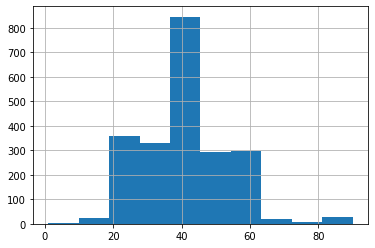

In [34]:
print(df_tv_shows_normalized.eps_duration.describe())
df_tv_shows_normalized.eps_duration.hist()

normal    1564
short      581
long        61
Name: eps_duration_dist, dtype: int64


Text(0.5, 0, 'Frequencia')

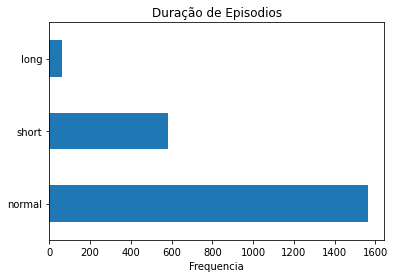

In [35]:
df_tv_shows_dist = df_tv_shows_normalized.copy()
# cria intervalos: [(-0.0005, 30], (30, 60], (60, 90]])
# estes intervalos foram especificados através do conhecimento dos dados
df_tv_shows_dist['eps_duration_dist'] = pd.cut(df_tv_shows_dist['eps_duration'], bins=[-0.0005, 30, 60, 90], labels=['short', 'normal', 'long'])
print(df_tv_shows_dist.eps_duration_dist.value_counts())

df_tv_shows_dist.eps_duration_dist.value_counts().plot(kind='barh')
plt.title('Duração de Episodios')
plt.xlabel('Frequencia')

In [36]:
df_tv_shows_dist[df_tv_shows_dist['eps_duration_dist'] == 'long'].head()

,name,changed_network,status,tv_network,metacritc_last_info_year,tvtime_followers,tvtime_rate,no_seasons,eps_duration,age_rating,imdb_rate,rotten_tomatoes_rate,released_year,awards_won,awards_nominated,tvtime_followers_norm,tvtime_rate_norm,imdb_rate_norm,rotten_tomatoes_rate_norm,eps_duration_dist
29,Abyss,0.0,-1.0,14.0,5.0,19962.0,4.83,1.0,65.0,-1.0,8.159386,76.067241,-1.0,0.0,0.0,0.004286,0.962389,0.825894,0.745396,long
86,American Idol,0.0,2.0,6.0,2.0,32363.0,3.41,17.0,85.0,2.0,4.100000,68.000000,19.0,8.0,43.0,0.006971,0.648230,0.298701,0.659574,long
88,American Ninja Warrior,0.0,3.0,13.0,7.0,11820.0,4.44,11.0,85.0,2.0,6.800000,92.823490,26.0,0.0,7.0,0.002523,0.876106,0.649351,0.923654,long
93,America's Got Talent,0.0,3.0,13.0,6.0,83417.0,3.75,14.0,85.0,2.0,5.800000,87.707864,23.0,0.0,4.0,0.018026,0.723451,0.519481,0.869233,long
94,America's Got Talent: The Champions,0.0,3.0,13.0,6.0,5371.0,4.31,2.0,85.0,-1.0,8.107644,75.323516,-1.0,0.0,0.0,0.001127,0.847345,0.819175,0.737484,long


#  PRE PROCESSAMENTO 2

## DETECÇÃO DE OUTLIERS

Método escolhido: `LocalOutlierFactor`

In [37]:
df_lof_input = df_tv_shows_dist.drop(columns=['name'])
df_lof_input['eps_duration_dist'] = df_lof_input['eps_duration_dist'].cat.codes

In [38]:
clf = LocalOutlierFactor(n_neighbors=10)
scores = clf.fit_predict(df_lof_input)

In [39]:
#Recuperando os dados categoricos
df_no_outliers = pd.DataFrame(columns=['name', 'changed_network', 'status', 'tv_network', 'metacritc_last_info_year', 'tvtime_followers', 'tvtime_rate', 'no_seasons', 'eps_duration', 'age_rating', 'imdb_rate', 'rotten_tomatoes_rate', 'released_year', 'awards_won', 'awards_nominated'])
df_no_outliers['name'] = df_tv_shows_dist['name']
df_no_outliers['changed_network'] = df_tv_shows_dist['changed_network']
df_no_outliers['status'] = df_tv_shows_categorical['status']
df_no_outliers['tv_network'] = df_tv_shows_categorical['tv_network']
df_no_outliers['metacritc_last_info_year'] = df_tv_shows_categorical['metacritc_last_info_year']
df_no_outliers['tvtime_followers'] = df_tv_shows_dist['tvtime_followers_norm']
df_no_outliers['tvtime_rate'] = df_tv_shows_dist['tvtime_rate_norm']
df_no_outliers['no_seasons'] = df_tv_shows_categorical['no_seasons']
df_no_outliers['eps_duration'] = df_tv_shows_dist['eps_duration_dist']
df_no_outliers['age_rating'] = df_tv_shows_categorical['age_rating']
df_no_outliers['imdb_rate'] = df_tv_shows_dist['imdb_rate_norm']
df_no_outliers['rotten_tomatoes_rate'] = df_tv_shows_dist['rotten_tomatoes_rate_norm']
df_no_outliers['released_year'] = df_tv_shows_categorical['released_year']
df_no_outliers['awards_won'] = df_tv_shows_categorical['awards_won']
df_no_outliers['awards_nominated'] = df_tv_shows_categorical['awards_nominated']


df_no_outliers['outliers'] = scores

df_tv_shows_final = df_no_outliers[df_no_outliers['outliers'] != -1]
df_tv_shows_final.drop(columns=['outliers'], inplace=True)

In [40]:
df_tv_shows_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2006 entries, 0 to 2205
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   name                      2006 non-null   object  
 1   changed_network           2006 non-null   float64 
 2   status                    1342 non-null   category
 3   tv_network                2006 non-null   category
 4   metacritc_last_info_year  2006 non-null   category
 5   tvtime_followers          2006 non-null   float64 
 6   tvtime_rate               2006 non-null   float64 
 7   no_seasons                1337 non-null   category
 8   eps_duration              2006 non-null   category
 9   age_rating                828 non-null    category
 10  imdb_rate                 2006 non-null   float64 
 11  rotten_tomatoes_rate      2006 non-null   float64 
 12  released_year             945 non-null    category
 13  awards_won                2006 non-null   catego

# ESTATÍSTICAS DESCRITIVAS

In [41]:
df_tv_shows_final.columns

Index(['name', 'changed_network', 'status', 'tv_network',
       'metacritc_last_info_year', 'tvtime_followers', 'tvtime_rate',
       'no_seasons', 'eps_duration', 'age_rating', 'imdb_rate',
       'rotten_tomatoes_rate', 'released_year', 'awards_won',
       'awards_nominated'],
      dtype='object')

Text(0.5, 1.0, 'Status das Series')

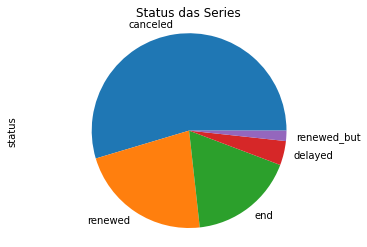

In [42]:
df_tv_shows_final.status.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Status das Series')

## Classificação Etária de séries Canceladas e Não Canceladas

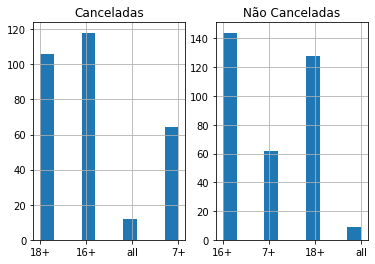

In [43]:
figure, axes = plt.subplots(1, 2)
df_tv_shows_final[df_tv_shows_final['status'] == 'canceled']['age_rating'].hist(ax=axes[0])
df_tv_shows_final[df_tv_shows_final['status'] != 'canceled']['age_rating'].hist(ax=axes[1])

axes[0].title.set_text('Canceladas')
axes[1].title.set_text('Não Canceladas')


## Analisando Relação entre a distribuição das notas do Rotten Tomatoes e do IMDB

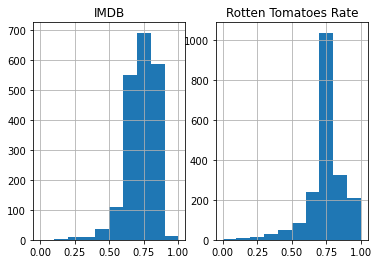

In [44]:
figure, axes = plt.subplots(1, 2)
df_tv_shows_final.imdb_rate.hist(ax=axes[0])
df_tv_shows_final.rotten_tomatoes_rate.hist(ax=axes[1])

axes[0].title.set_text('IMDB')
axes[1].title.set_text('Rotten Tomatoes Rate')


In [45]:
print('moda:', df_tv_shows_final['imdb_rate'].mode())
df_tv_shows_final['imdb_rate'].describe()

moda: 0    0.678509
dtype: float64


count    2006.000000
mean        0.733272
std         0.100977
min         0.000000
25%         0.678509
50%         0.740260
75%         0.808824
max         1.000000
Name: imdb_rate, dtype: float64

In [46]:
print('moda:', df_tv_shows_final['rotten_tomatoes_rate'].mode())
df_tv_shows_final['rotten_tomatoes_rate'].describe()

moda: 0    0.78392
dtype: float64


count    2006.000000
mean        0.751532
std         0.134805
min         0.000000
25%         0.712669
50%         0.771951
75%         0.816204
max         1.000000
Name: rotten_tomatoes_rate, dtype: float64

In [47]:
print('moda:', df_tv_shows_final['tvtime_rate'].mode())
df_tv_shows_final['tvtime_rate'].describe()

moda: 0    0.883811
dtype: float64


count    2006.000000
mean        0.790302
std         0.117058
min         0.000000
25%         0.725664
50%         0.800885
75%         0.879425
max         1.000000
Name: tvtime_rate, dtype: float64

## Analisando se a avalição pública está correlacionada com o numero de tempordas

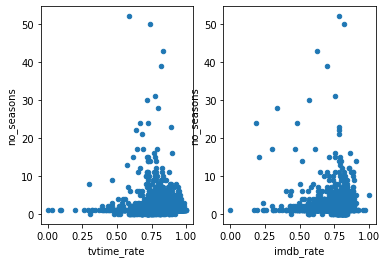

In [48]:

figure, axes = plt.subplots(1, 2)
df_tv_shows_final.plot.scatter(x='tvtime_rate', y='no_seasons', ax=axes[0])
df_tv_shows_final.plot.scatter(x='imdb_rate', y='no_seasons', ax=axes[1])


# TESTE DE HIPOTESE

## Analisando a correlação entre as notas de TV TIME, IMDB e Rotten Tomatoes 

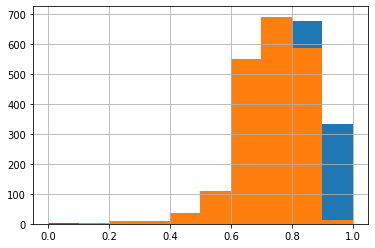

In [49]:
df_tv_shows_final['tvtime_rate'].hist()
df_tv_shows_final['imdb_rate'].hist()

In [50]:
correlations = df_tv_shows_final.corr(method='spearman')
print(" Correlação entre tvtime_rate e imdb_rate:",correlations['tvtime_rate']['imdb_rate'])
print(" Correlação entre tvtime_rate e rotten_tomatoes_rate:",correlations['tvtime_rate']['rotten_tomatoes_rate'])
print(" Correlação entre rotten_tomatoes_rate e imdb_rate:", correlations['rotten_tomatoes_rate']['imdb_rate'])

 Correlação entre tvtime_rate e imdb_rate: 0.16800519891301724
 Correlação entre tvtime_rate e rotten_tomatoes_rate: 0.1352591455713874
 Correlação entre rotten_tomatoes_rate e imdb_rate: 0.1520281029868621


Porem os valores estão proximos de zero. Não existe uma correlação entre eles.

## Analisando distribuição das notas da series canceladas e renovadas

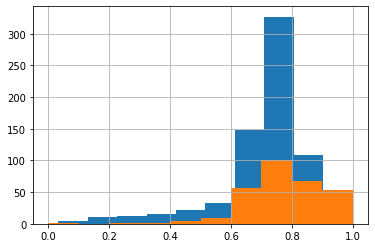

In [51]:
df_tv_shows_final[df_tv_shows_final['status'] == 'canceled']['rotten_tomatoes_rate'].hist()
df_tv_shows_final[df_tv_shows_final['status'] == 'renewed']['rotten_tomatoes_rate'].hist()

In [52]:
data1 = df_tv_shows_final[df_tv_shows_final['status'] == 'canceled']['rotten_tomatoes_rate']
data2 = df_tv_shows_final[df_tv_shows_final['status'] == 'renewed']['rotten_tomatoes_rate']
stats.mannwhitneyu(data1, data2)

MannwhitneyuResult(statistic=85966.5, pvalue=6.072989491068197e-08)

Como o p-value é menor que 0.05, a hipótese nula pode ser rejeitada, ou seja, a distribuição da nota do Rotten tomatoes (opinião técnica) é diferente para séries canceladas e renovadas.

In [53]:
data1 = df_tv_shows_final[df_tv_shows_final['status'] == 'canceled']['tvtime_rate']
data2 = df_tv_shows_final[df_tv_shows_final['status'] == 'renewed']['tvtime_rate']
stats.mannwhitneyu(data1, data2)

MannwhitneyuResult(statistic=74900.5, pvalue=2.0796629678540986e-15)

O mesmo acontece para o tv time

In [54]:
data1 = df_tv_shows_final[df_tv_shows_final['status'] == 'canceled']['imdb_rate']
data2 = df_tv_shows_final[df_tv_shows_final['status'] == 'renewed']['imdb_rate']
stats.mannwhitneyu(data1, data2)

MannwhitneyuResult(statistic=104893.0, pvalue=0.18008456716933968)

Porem para o IMDB não é possivel afirmar a mesma coisa